In [1]:
# !pip install kagglehub
# !pip install tensorflow
# !pip install scikit-learn
# !pip install scikit-image


In [2]:
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
import matplotlib.pyplot as plt
import numpy as np
from skimage.feature import hog
import pandas as pd
from sklearn.feature_selection import VarianceThreshold, SelectPercentile, f_classif
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, ConfusionMatrixDisplay, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, ConfusionMatrixDisplay
import numpy as np

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()


x_train = x_train / 255.0
x_test = x_test / 255.0

# 1.3. Dacă este necesar, adaugă un canal suplimentar pentru imagini grayscale
x_train = x_train[..., np.newaxis]
x_test = x_test[..., np.newaxis]

print(f"x_train shape: {x_train.shape}, y_train shape: {y_train.shape}")

x_train shape: (60000, 28, 28, 1), y_train shape: (60000,)


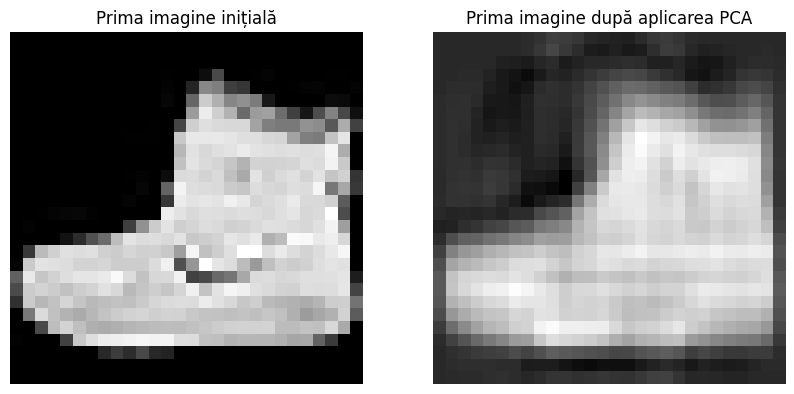

In [3]:

# Reshape x_train to 2D
x_train_flat = x_train.reshape(x_train.shape[0], -1)

pca = PCA(n_components=50)
dataIn2D = pca.fit_transform(x_train_flat)
reconstructed_image_pca = pca.inverse_transform(dataIn2D[0]).reshape(28, 28)

plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
plt.imshow(x_train[0].squeeze(), cmap='gray')
plt.title("Prima imagine inițială")
plt.axis('off')

plt.subplot(1, 2, 2)
plt.imshow(reconstructed_image_pca, cmap='gray')
plt.title("Prima imagine după aplicarea PCA")
plt.axis('off')


plt.show()

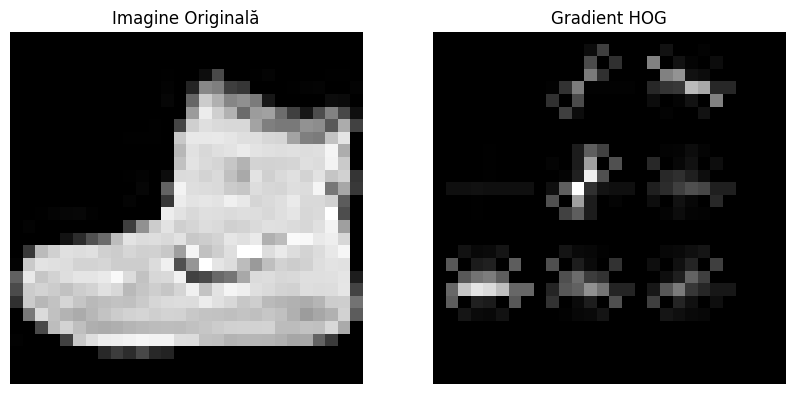

In [4]:
image_sample = x_train[0].squeeze()
_, hog_image = hog(image_sample, orientations=9, pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2), visualize=True)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image_sample, cmap='gray')
plt.axis('off')
plt.title("Imagine Originală")

plt.subplot(1, 2, 2)
plt.imshow(hog_image, cmap='gray')
plt.title("Gradient HOG")
plt.axis('off')
plt.show()


### 4.2

<Figure size 2000x800 with 0 Axes>

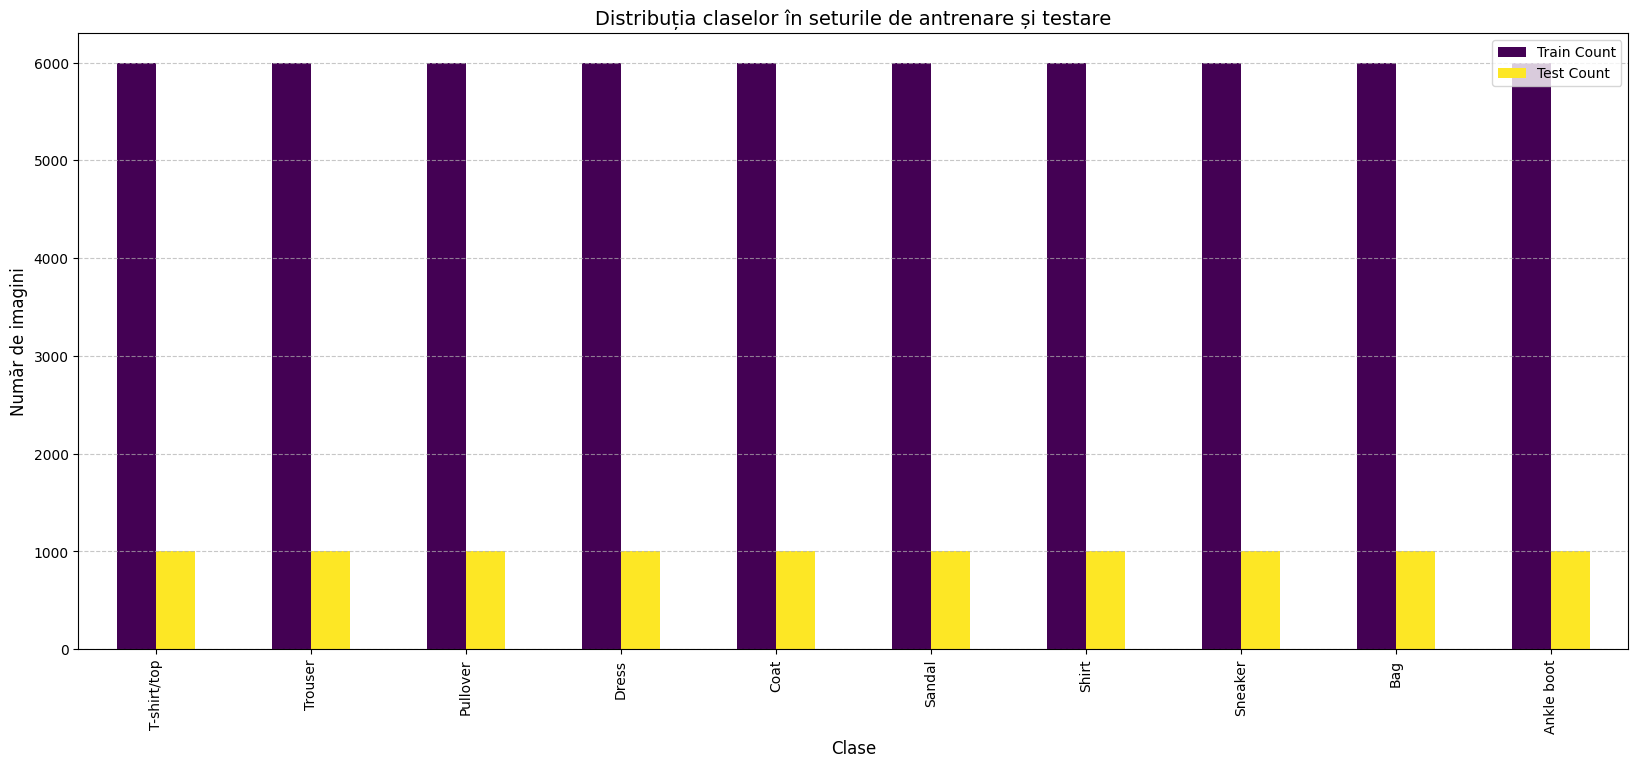

In [5]:
unique_train, counts_train = np.unique(y_train, return_counts=True)
class_distribution_train = dict(zip(unique_train, counts_train))

unique_test, counts_test = np.unique(y_test, return_counts=True)
class_distribution_test = dict(zip(unique_test, counts_test))

# Numele claselor
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

# Combinare distribuții într-un singur DataFrame
combined_df = pd.DataFrame({
    'Class': class_names,
    'Train Count': class_distribution_train.values(),
    'Test Count': class_distribution_test.values()
})

# Vizualizare distribuții
plt.figure(figsize=(20, 8))
combined_df.set_index('Class').plot(kind='bar', colormap='viridis', figsize=(20, 8))
plt.xticks(rotation=90, fontsize=10)
plt.title('Distribuția claselor în seturile de antrenare și testare', fontsize=14)
plt.xlabel('Clase', fontsize=12)
plt.ylabel('Număr de imagini', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

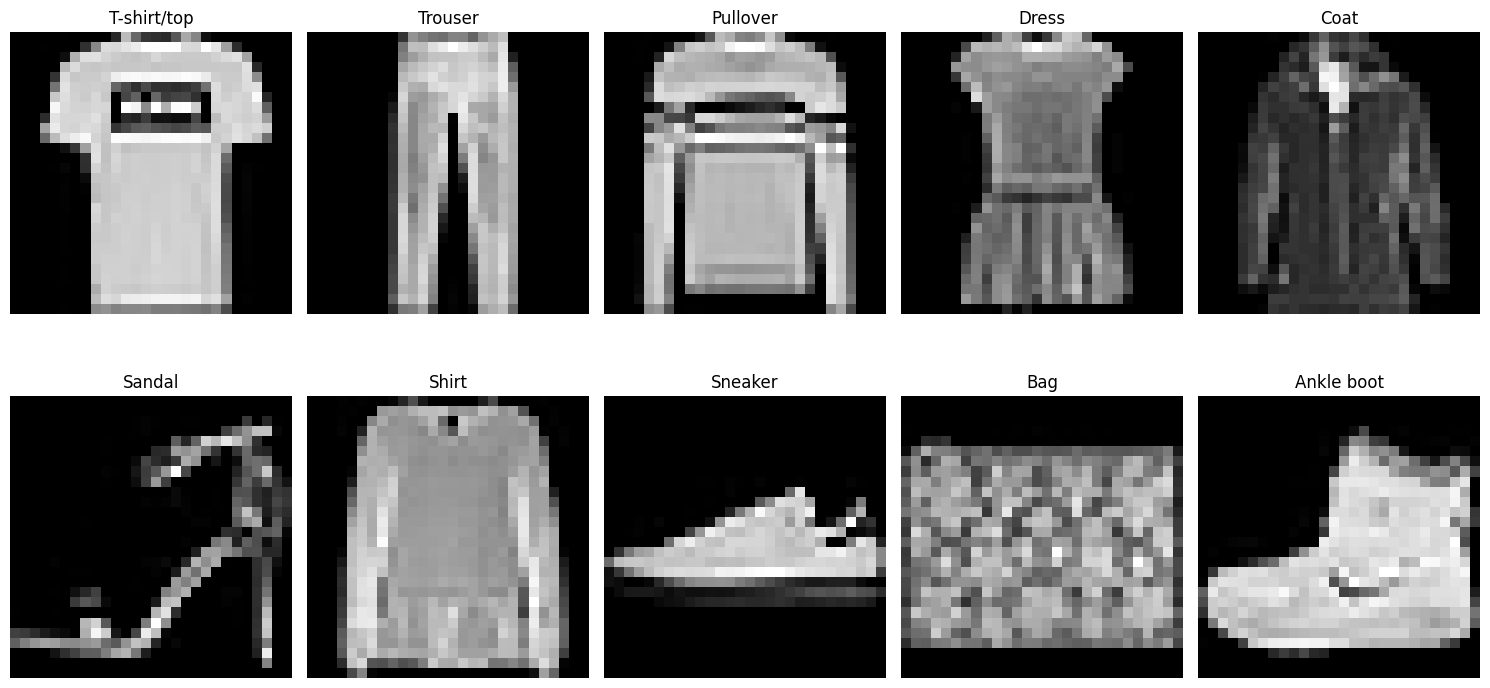

In [6]:
plt.figure(figsize=(15, 8))
for i, class_name in enumerate(class_names):
    image_sample = x_train[y_train == i][0]
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_sample, cmap='gray')
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

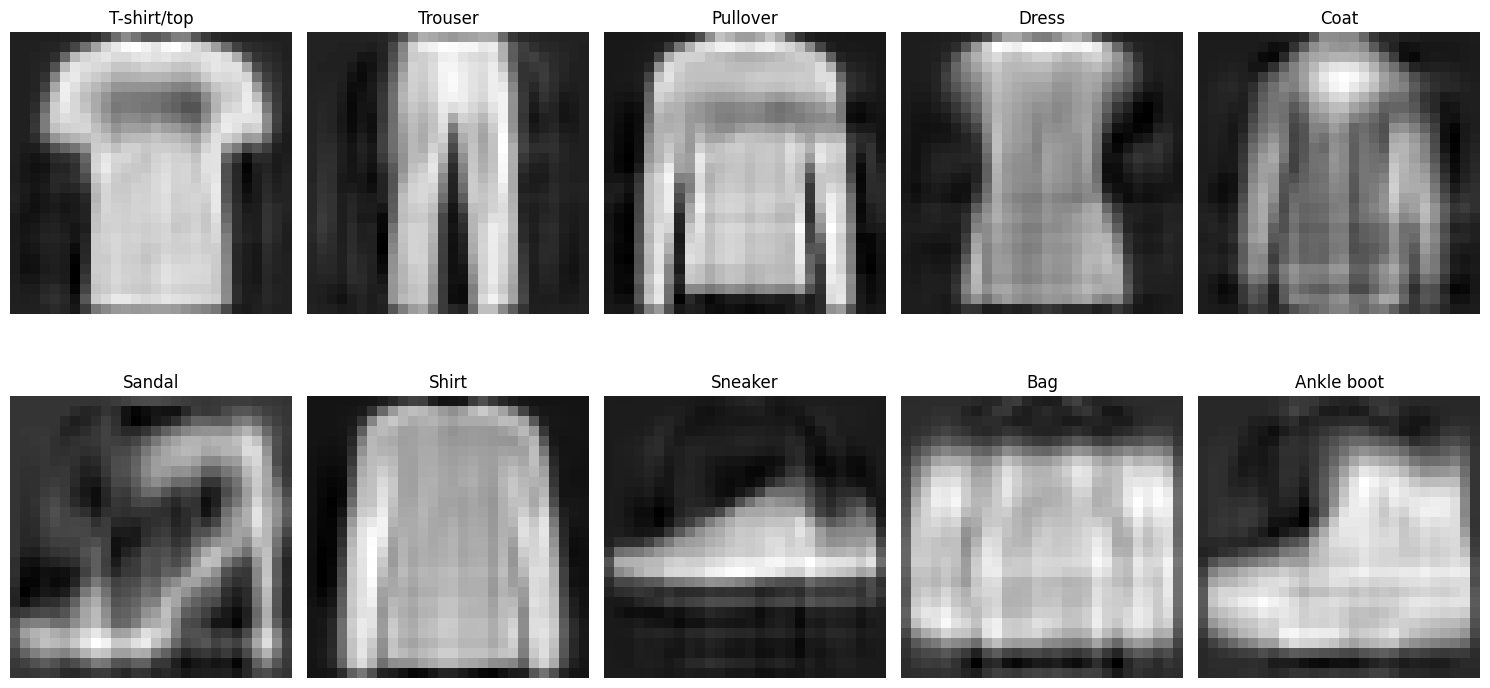

In [7]:
# Reshape x_train and x_test to 2D
x_train_flat = x_train.reshape(x_train.shape[0], -1)
x_test_flat = x_test.reshape(x_test.shape[0], -1)

pca = PCA(n_components=50)
x_test_pca = pca.fit_transform(x_test_flat)

# Aplică PCA pe toate pozele
pca = PCA(n_components=50)
x_train_pca = pca.fit_transform(x_train_flat)

# Reconstruiește primele imagini din setul de antrenament și testare
reconstructed_image_train_pca = pca.inverse_transform(x_train_pca[0]).reshape(28, 28)

plt.figure(figsize=(15, 8))
for i, class_name in enumerate(class_names):
    image_sample = x_train_pca[y_train == i][0]
    image_sample = pca.inverse_transform(image_sample).reshape(28, 28)
    plt.subplot(2, 5, i + 1)
    plt.imshow(image_sample, cmap='gray')
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()

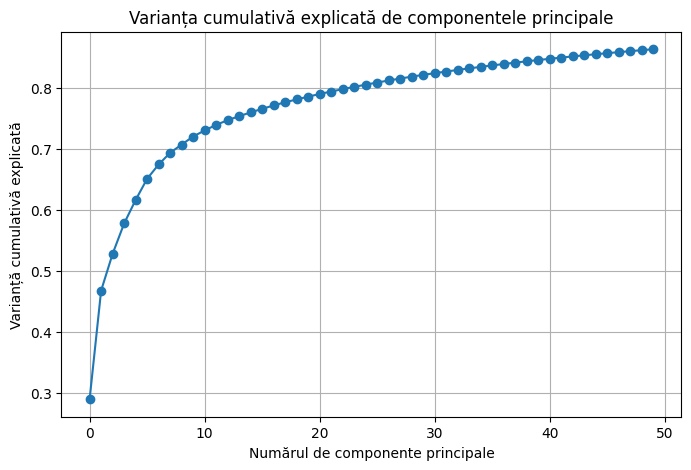

In [8]:
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca.explained_variance_ratio_), marker='o')
plt.title("Varianța cumulativă explicată de componentele principale")
plt.xlabel("Numărul de componente principale")
plt.ylabel("Varianță cumulativă explicată")
plt.grid()
plt.show()

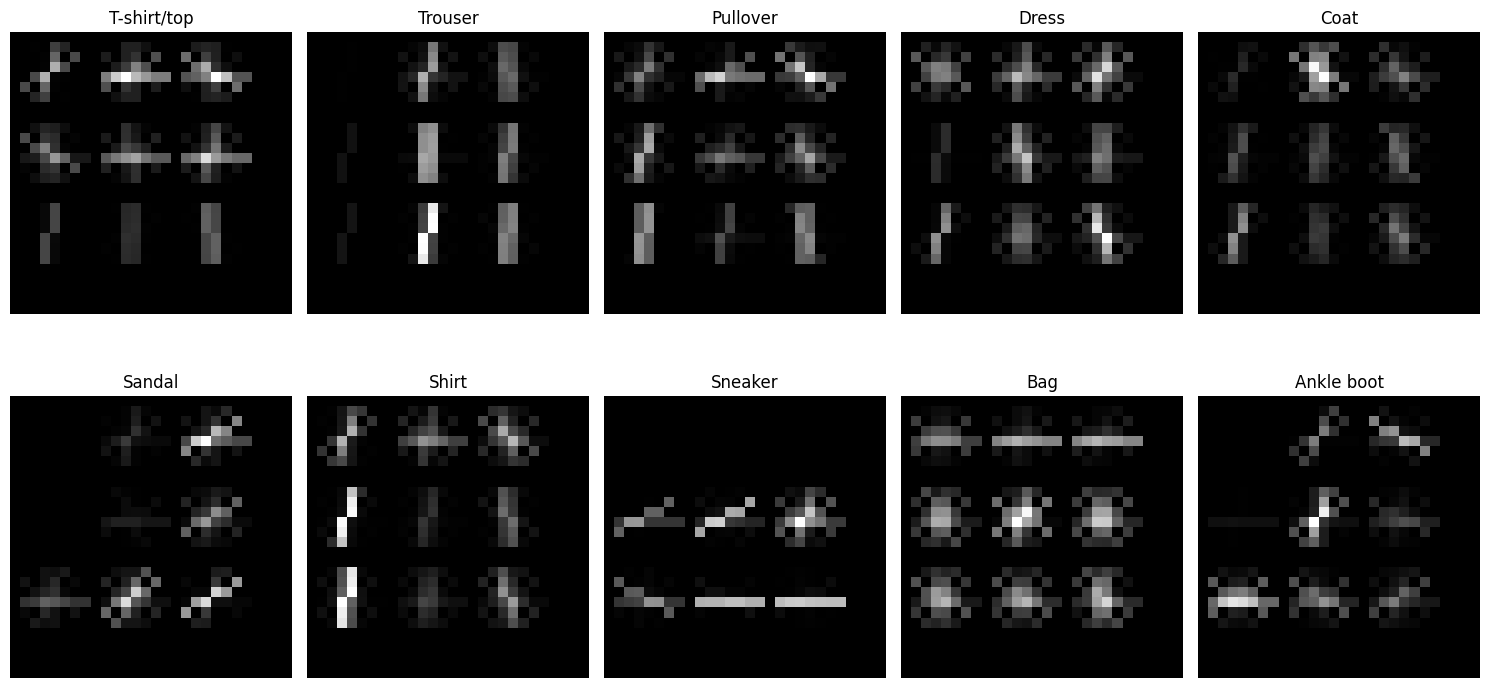

In [9]:


plt.figure(figsize=(15, 8))
for i, class_name in enumerate(class_names):
    image_sample = x_train[y_train == i][0]

    image_sample = image_sample.squeeze()
    _, hog_image = hog(image_sample, orientations=9, pixels_per_cell=(8, 8),
                    cells_per_block=(2, 2), visualize=True)

    plt.subplot(2, 5, i + 1)
    plt.imshow(hog_image, cmap='gray')
    plt.title(class_name)
    plt.axis('off')
plt.tight_layout()
plt.show()


In [10]:
def apply_hog_fixed(images):
    hog_features = []
    for img in images:
        # Extragere HOG
        feature, _= hog(img.squeeze(), orientations=9, pixels_per_cell=(8, 8),
                         cells_per_block=(2, 2), visualize=True)
        hog_features.append(feature)
    return np.array(hog_features)

hog_features_train = apply_hog_fixed(x_train)
hog_features_test = apply_hog_fixed(x_test)

print(f"HOG Features Train Shape: {hog_features_train.shape}")
print(f"HOG Features Test Shape: {hog_features_test.shape}")

# Standardizare


# # Verificare
# hog_train_mean = x_train_hog_standardized.mean(axis=0)
# hog_train_std = x_train_hog_standardized.std(axis=0)

# hog_test_mean = x_test_hog_standardized.mean(axis=0)
# hog_test_std = x_test_hog_standardized.std(axis=0)

# print("HOG Train mean:", hog_train_mean[:10])  # Doar primele 10 valori
# print("HOG Train std:", hog_train_std[:10])
# print("HOG Test mean:", hog_test_mean[:10])
# print("HOG Test std:", hog_test_std[:10])


HOG Features Train Shape: (60000, 144)
HOG Features Test Shape: (10000, 144)


In [11]:


scaler = StandardScaler()

scaler.fit(x_train_pca)

x_train_pca_standardized = scaler.transform(x_train_pca)
# print(x_train_pca.shape, x_train_pca_standardized.shape)

x_test_pca_standardized = scaler.transform(x_test_pca)
# print(x_test_pca.shape, x_test_pca_standardized.shape)


scaler_hog = StandardScaler()
x_train_hog_standardized = scaler_hog.fit_transform(hog_features_train)
x_test_hog_standardized = scaler_hog.transform(hog_features_test)

x_train_combined = np.hstack((x_train_pca_standardized, x_train_hog_standardized))
x_test_combined = np.hstack((x_test_pca_standardized, x_test_hog_standardized))

variance_threshold = VarianceThreshold(threshold=1)
x_train_variance = variance_threshold.fit_transform(x_train_combined)
x_test_variance = variance_threshold.transform(x_test_combined)

print("Dimensiuni înainte și după Variance Threshold:")
print(f"Inițial: {x_train_variance.shape}, După: {x_train_combined.shape}")
print(f"Inițial: {x_test_variance.shape}, După: {x_test_combined.shape}")

Dimensiuni înainte și după Variance Threshold:
Inițial: (60000, 105), După: (60000, 194)
Inițial: (10000, 105), După: (10000, 194)


Accuracy (Combined PCA + HOG): 0.6236
Classification Report (Combined PCA + HOG):
              precision    recall  f1-score   support

 T-shirt/top       0.40      0.72      0.52      1000
     Trouser       0.92      0.93      0.92      1000
    Pullover       0.66      0.39      0.49      1000
       Dress       0.78      0.69      0.73      1000
        Coat       0.71      0.55      0.62      1000
      Sandal       0.40      0.58      0.47      1000
       Shirt       0.36      0.34      0.35      1000
     Sneaker       0.65      0.83      0.73      1000
         Bag       0.95      0.95      0.95      1000
  Ankle boot       0.90      0.26      0.40      1000

    accuracy                           0.62     10000
   macro avg       0.67      0.62      0.62     10000
weighted avg       0.67      0.62      0.62     10000



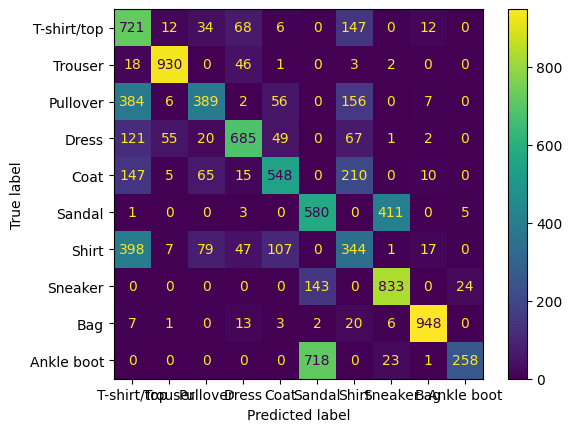

In [12]:


# Combinarea atributelor PCA și HOG
# x_train_combined = np.hstack((x_train_pca_standardized, x_train_hog_standardized))
# x_test_combined = np.hstack((x_test_pca_standardized, x_test_hog_standardized))

# Crearea modelului Logistic Regression
log_reg_combined = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='lbfgs')

# Antrenarea modelului pe datele combinate
log_reg_combined.fit(x_train_variance, y_train)

# Predicția pe setul de testare combinat
y_pred_combined = log_reg_combined.predict(x_test_variance)

# Evaluarea performanței modelului
accuracy_combined = accuracy_score(y_test, y_pred_combined)
report_combined = classification_report(y_test, y_pred_combined, target_names=class_names)

# Afișarea rezultatelor
print(f"Accuracy (Combined PCA + HOG): {accuracy_combined}")
print("Classification Report (Combined PCA + HOG):")
print(report_combined)

# Vizualizarea matricii de confuzie
ConfusionMatrixDisplay.from_estimator(log_reg_combined, x_test_variance, y_test, display_labels=class_names)


In [13]:


# # Definirea modelului Logistic Regression
# log_reg = LogisticRegression(max_iter=150)

# # Definirea intervalelor de hiper-parametri pentru căutare
# param_grid = {
#     "C": np.logspace(-2, 2, 10),#np.logspace(-4, 4, 10),  # Regularizare (valori între 10^-4 și 10^4)
#     "multi_class": ["ovr", "multinomial"]  # Metodologia de clasificare
# }


# random_search = RandomizedSearchCV(log_reg, param_grid, cv=5, n_iter=10, random_state=42)

# # Antrenarea și căutarea celor mai buni hiper-parametri
# random_search.fit(x_train_variance, y_train)

# # Cel mai bun model și hiper-parametrii săi
# best_model = random_search.best_estimator_
# best_params = random_search.best_params_

# # Predicția pe setul de testare combinat
# y_pred_combined = best_model.predict(x_test_variance)

# # Evaluarea performanței
# accuracy_combined = accuracy_score(y_test, y_pred_combined)
# report_combined = classification_report(y_test, y_pred_combined, target_names=class_names)

# # Afișarea rezultatelor
# print(f"Cei mai buni hiper-parametri: {best_params}")
# print(f"Accuracy (Combined PCA + HOG): {accuracy_combined}")
# print("Classification Report (Combined PCA + HOG):")
# print(report_combined)

# # Vizualizarea matricii de confuzie
# ConfusionMatrixDisplay.from_estimator(best_model, x_test_variance, y_test, display_labels=class_names)



In [ ]:

# Definirea modelului SVM
svm_model = SVC()

# Definirea intervalelor de hiper-parametri pentru căutare
# param_grid_svm = {
#     "C": np.logspace(-2, 2, 10),  # Regularizare (valori între 10^-2 și 10^2)
#     "kernel": ["linear", "poly", "rbf", "sigmoid"]  # Tipul de kernel
# }
param_grid_svm = {
        'C': [0.1, 1, 10, 100],
        'kernel': ['linear', 'rbf', 'sigmoid']
    }
# Configurarea RandomizedSearchCV
random_search_svm = RandomizedSearchCV(
    estimator=svm_model,
    param_distributions=param_grid_svm,
    n_iter=10,  # Numărul de combinații de hiper-parametri de încercat
    scoring="accuracy",
    cv=5,  # Cross-validation pe 3 fold-uri
    verbose=0,
    random_state=42
    #n_jobs=-1  # Utilizează toate nucleele disponibile
)

# Antrenarea și căutarea celor mai buni hiper-parametri
random_search_svm.fit(x_train_variance, y_train)

# Cel mai bun model și hiper-parametrii săi
best_svm_model = random_search_svm.best_estimator_
best_svm_params = random_search_svm.best_params_

# Predicția pe setul de testare combinat
y_pred_svm = best_svm_model.predict(x_test_variance)

# Evaluarea performanței
accuracy_svm = accuracy_score(y_test, y_pred_svm)
report_svm = classification_report(y_test, y_pred_svm, target_names=class_names)

# Afișarea rezultatelor
print(f"Cei mai buni hiper-parametri SVM: {best_svm_params}")
print(f"Accuracy SVM (Combined PCA + HOG): {accuracy_svm}")
print("Classification Report SVM:")
print(report_svm)

# Vizualizarea matricii de confuzie
ConfusionMatrixDisplay.from_estimator(best_svm_model, x_test_variance, y_test, display_labels=class_names).plot()
